In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import KFold
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, ElasticNet, Ridge
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error
from sklearn.cross_decomposition import PLSRegression

# another way of ignoring warnings
warnings.filterwarnings('ignore')

In [35]:
### Importing data
df = pd.read_csv("case1Data.csv")
y = df.iloc[:, 0]
X = df.iloc[:, 1:]
df.head(10)

,y,x_01,x_02,x_03,x_04,x_05,x_06,x_07,x_08,x_09,...,x_91,x_92,x_93,x_94,x_95,C_01,C_02,C_03,C_04,C_05
0,375.823073,6.359019,-13.367120,-2.483750,-6.641891,11.733539,NaN,-17.085361,22.194764,16.827888,...,-10.200888,3.980048,-4.433274,-1.473723,NaN,74.0,72.0,72.0,73.0,73.0
1,266.811730,3.873664,-8.470389,-3.055012,NaN,11.420983,1.822330,-13.694100,22.738654,20.307503,...,-9.740207,NaN,-2.629314,4.816987,-12.240248,74.0,72.0,72.0,73.0,73.0
2,267.271759,5.275824,-12.070531,-1.366168,-4.819100,10.721527,-5.125992,-17.476865,NaN,15.963889,...,-14.501970,10.054005,NaN,NaN,-11.107921,73.0,72.0,75.0,74.0,74.0
3,219.951294,4.430110,-4.467975,-0.730736,-10.047104,11.498539,-2.870260,-14.033012,18.225190,10.409488,...,-11.086963,2.019726,-8.531959,3.520833,NaN,71.0,72.0,73.0,71.0,72.0
4,289.697954,3.116458,-8.518713,-6.796050,NaN,7.646285,-3.118309,-13.102567,22.801217,16.680208,...,-9.117422,6.627601,-2.805531,5.914351,-11.240573,72.0,72.0,72.0,74.0,75.0
5,265.753204,2.478883,-10.347278,-3.574333,-4.320143,NaN,-3.326662,-13.197508,23.424267,12.551075,...,-11.571283,7.487204,-5.098366,3.175914,-9.610356,71.0,72.0,74.0,71.0,75.0
6,133.594186,0.497803,-9.389992,-7.230404,-8.852222,12.308068,-5.288380,-9.998207,23.229430,13.491712,...,-15.720359,NaN,-6.235942,4.124001,-16.268568,74.0,72.0,75.0,71.0,75.0
7,252.251096,7.627311,-7.146660,0.244472,0.182987,NaN,-0.395215,-14.423119,NaN,NaN,...,-10.710254,7.884195,-2.402023,NaN,-4.631043,74.0,72.0,73.0,75.0,73.0
8,163.402815,4.981034,-8.719028,-5.484942,-5.919929,9.916674,-4.726807,-10.606375,24.903043,12.151393,...,-11.139651,7.096430,-2.865486,7.464922,-8.441735,NaN,NaN,NaN,NaN,NaN
9,282.511836,0.519655,-14.477831,-2.121282,NaN,12.080162,-6.393721,-11.599432,NaN,11.984299,...,-14.195198,2.409425,-3.523658,2.821658,-14.591262,75.0,72.0,72.0,74.0,71.0


In [36]:
def center_dataframe(data):
    mu = data.mean()
    data = data - mu
    return data, mu

In [37]:
def handlingOfdata(Xtrain, Xtest, ytrain, ytest):
    # train set
    Xtrain_cont = Xtrain.iloc[:, :95]
    Xtrain_cat = Xtrain.iloc[:, 95:]

    # test set
    Xtest_cont = Xtest.iloc[:, :95]
    Xtest_cat = Xtest.iloc[:, 95:]

    #centering of the target values
    ytrain_centr, miu = center_dataframe(ytrain)
    ytest_centr = ytest-miu

    # --- Scaling Continuous Variables ---
    standard_scaler = StandardScaler()
    Xtrain_cont_scaled = standard_scaler.fit_transform(Xtrain_cont)
    Xtest_cont_scaled = standard_scaler.transform(Xtest_cont)

    # --- KNN Imputation for Continuous Variables ---
    knn_imput = KNNImputer(n_neighbors=5)
    X_train_cont_imputed = knn_imput.fit_transform(Xtrain_cont_scaled)
    X_test_cont_imputed = knn_imput.transform(Xtest_cont_scaled)

    # Convert to DataFrame 
    X_train_cont_imputed = pd.DataFrame(X_train_cont_imputed, columns=Xtrain_cont.columns, index=Xtrain_cont.index)
    X_test_cont_imputed = pd.DataFrame(X_test_cont_imputed, columns=Xtest_cont.columns, index=Xtest_cont.index)

    # --- Imputation for Categorical Variables ---
    simple_imput = SimpleImputer(strategy="most_frequent")
    Xtrain_cat_imputed = simple_imput.fit_transform(Xtrain_cat)
    Xtest_cat_imputed = simple_imput.transform(Xtest_cat)

    # Convert to DataFrame 
    Xtrain_cat_imputed = pd.DataFrame(Xtrain_cat_imputed, columns=Xtrain_cat.columns, index=Xtrain_cat.index)
    Xtest_cat_imputed = pd.DataFrame(Xtest_cat_imputed, columns=Xtest_cat.columns, index=Xtest_cat.index)

    # --- 1 HOT encoding ---
    Xtrain_cat_imputed1HOT = pd.get_dummies(Xtrain_cat_imputed, columns=Xtrain_cat_imputed.columns, drop_first=False).astype(int)
    Xtest_cat_imputed1HOT = pd.get_dummies(Xtest_cat_imputed, columns=Xtrain_cat_imputed.columns, drop_first=False).astype(int)
    # Ensure that both train and test have the same columns
    Xtest_cat_imputed1HOT = Xtest_cat_imputed1HOT.reindex(columns=Xtrain_cat_imputed1HOT.columns, fill_value=0)

    # --- Align the target variable with the feature DataFrames ---
    # --- for Regression models ---
    # --- Concatenate Continuous and Categorical Data ---
    Xtrain_final = pd.concat([X_train_cont_imputed, Xtrain_cat_imputed1HOT], axis=1)
    Xtest_final = pd.concat([X_test_cont_imputed, Xtest_cat_imputed1HOT], axis=1)

    return Xtrain_final, Xtest_final, ytrain_centr, ytest_centr


# Ridge

In [66]:
# Define hyperparameter grid
alphas = np.linspace(0, 100, 100)

# Outer cross-validation (e.g., 10-fold)
outer_cv = KFold(n_splits=10, shuffle=True, random_state=1)

# Store results
test_r2 = []
test_RMSE = []
test_MSE = []

# Store R² scores for all alphas in all folds
all_alpha_scores = []

# Initialize alpha_means and alpha_stds as empty lists
alpha_means = []
alpha_stds = []

# Outer cross-validation loop
for train_idx, test_idx in outer_cv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    X_train, X_test, y_train, y_test = handlingOfdata(X_train, X_test, y_train, y_test)

    # Inner cross-validation for hyperparameter tuning
    best_score = -np.inf
    best_alpha = None

    inner_cv = KFold(n_splits=10, shuffle=True, random_state=1)

    fold_alpha_scores = []  # To store R² scores for each alpha in the current fold

    # Initialize a list to store mean and std for each alpha across inner folds
    inner_alpha_means = []
    inner_alpha_stds = []

    for alpha in alphas:
        inner_r2, inner_RMSE, inner_MSE = [], [], []
        for inner_train_idx, inner_val_idx in inner_cv.split(X_train):
            X_inner_train, X_val = X_train.iloc[inner_train_idx], X_train.iloc[inner_val_idx]
            y_inner_train, y_val = y_train.iloc[inner_train_idx], y_train.iloc[inner_val_idx]

            model = Ridge(alpha=alpha)
            model.fit(X_inner_train, y_inner_train)
            inner_r2.append(r2_score(y_val, model.predict(X_val)))
            inner_RMSE.append(root_mean_squared_error(y_val, model.predict(X_val)))
            inner_MSE.append(mean_squared_error(y_val, model.predict(X_val)))

        # Calculate mean and std for each alpha across inner folds
        mean_inner_r2 = np.mean(inner_r2)
        std_inner_r2 = np.std(inner_r2)

        inner_alpha_means.append(mean_inner_r2)
        inner_alpha_stds.append(std_inner_r2)

        fold_alpha_scores.append(mean_inner_r2)  # Store the mean R² score for the current alpha

        if mean_inner_r2 > best_score:
            best_score = mean_inner_r2
            best_alpha = alpha

    # Store the R² scores for all alphas in this fold
    all_alpha_scores.append(fold_alpha_scores)

    # Add the inner alpha means and stds for the current fold to the overall list
    alpha_means.append(inner_alpha_means)
    alpha_stds.append(inner_alpha_stds)

    # Train final model with best alpha on full outer training set
    final_model = Ridge(alpha=best_alpha)
    final_model.fit(X_train, y_train)

    # Evaluate on outer test set
    y_pred = final_model.predict(X_test)
    test_r2.append(r2_score(y_test, y_pred))
    test_RMSE.append(root_mean_squared_error(y_test, y_pred))
    test_MSE.append(mean_squared_error(y_test, y_pred))

# Convert alpha_means and alpha_stds into NumPy arrays for easier indexing
alpha_means = np.array(alpha_means)  # Shape will be (n_folds, n_alphas)
alpha_stds = np.array(alpha_stds)    # Shape will be (n_folds, n_alphas)

# Report final performance estimate
print("Final estimated R² score (mean over outer folds):", np.mean(test_r2))
print("Final estimated MSE score (mean over outer folds):", np.mean(test_MSE))
print("Final estimated RMSE score (mean over outer folds):", np.mean(test_RMSE))

Final estimated R² score (mean over outer folds): 0.7346203071807736
Final estimated MSE score (mean over outer folds): 1007.7273892021973
Final estimated RMSE score (mean over outer folds): 31.107160221431645


In [67]:
# Apply the One Standard Error Rule

# Get the best model's mean R² score and std deviation across all folds
mean_r2_all_folds = np.mean(alpha_means, axis=0)
std_r2_all_folds = np.mean(alpha_stds, axis=0)

# Find the models where mean R² is within 1 standard error of the best R²
best_mean_r2 = np.max(mean_r2_all_folds)
best_std_r2 = std_r2_all_folds[np.argmax(mean_r2_all_folds)]  # Corresponding std for the best mean

acceptable_models = [i for i, mean_r2 in enumerate(mean_r2_all_folds) if best_mean_r2 - best_std_r2 <= mean_r2]

# Select the model with the highest alpha among the acceptable models
if len(acceptable_models) > 0:
    selected_model_idx = acceptable_models[-1]  # Select the most regularized model
else:
    selected_model_idx = np.argmax(mean_r2_all_folds)  # If no model satisfies the rule, keep the best one

# Print the hyperparameters of the selected model
print(f'One standard error rule selects model with alpha: {alphas[selected_model_idx]}')
print(f'One standard error rule gives the best model with mean_test_score (R²): {mean_r2_all_folds[selected_model_idx]} and std_test_score: {std_r2_all_folds[selected_model_idx]}')

One standard error rule selects model with alpha: 61.61616161616162
One standard error rule gives the best model with mean_test_score (R²): 0.5749199511848035 and std_test_score: 0.1749693978267816


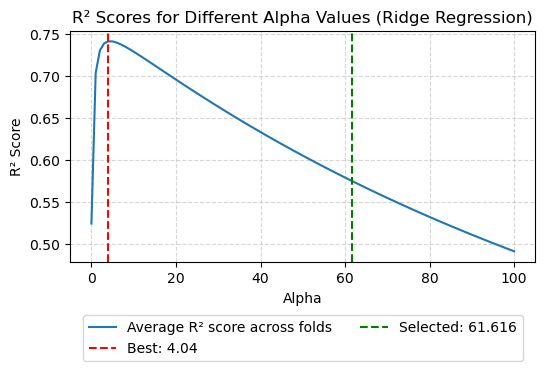

In [68]:
plt.figure(figsize=(6, 3))
mean_alpha_scores = np.mean(all_alpha_scores, axis=0)  # Average R² score for each alpha across all folds
plt.plot(alphas, mean_alpha_scores, label='Average R² score across folds')

# Round values to 3 decimal places
best_alpha_rounded = round(best_alpha, 3)
selected_alpha_rounded = round(alphas[selected_model_idx], 3)

plt.axvline(best_alpha, color='r', linestyle='--', label=f"Best: {best_alpha_rounded}")
plt.axvline(alphas[selected_model_idx], color='g', linestyle='--', label=f"Selected: {selected_alpha_rounded}")

plt.xlabel('Alpha')
plt.ylabel('R² Score')
plt.title('R² Scores for Different Alpha Values (Ridge Regression)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)  # Move legend below the graph
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Standard deviation vlaues are pretty high and therefore when 1-std-rule is applied we pick model with performing significantly worse.

# Lasso

In [49]:
# Define hyperparameter grid
alphas = np.linspace(0, 10, 100)

# Outer cross-validation (e.g., 10-fold)
outer_cv = KFold(n_splits=10, shuffle=True, random_state=1)

# Store results
test_r2 = []
test_RMSE = []
test_MSE = []

# Store R² scores for all alphas in all folds
all_alpha_scores = []

# Initialize alpha_means and alpha_stds as empty lists
alpha_means = []
alpha_stds = []

# Outer cross-validation loop
for train_idx, test_idx in outer_cv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    X_train, X_test, y_train, y_test = handlingOfdata(X_train, X_test, y_train, y_test)

    # Inner cross-validation for hyperparameter tuning
    best_score = -np.inf
    best_alpha = None

    inner_cv = KFold(n_splits=10, shuffle=True, random_state=1)

    fold_alpha_scores = []  # To store R² scores for each alpha in the current fold

    # Initialize a list to store mean and std for each alpha across inner folds
    inner_alpha_means = []
    inner_alpha_stds = []

    for alpha in alphas:
        inner_r2, inner_RMSE, inner_MSE = [], [], []
        for inner_train_idx, inner_val_idx in inner_cv.split(X_train):
            X_inner_train, X_val = X_train.iloc[inner_train_idx], X_train.iloc[inner_val_idx]
            y_inner_train, y_val = y_train.iloc[inner_train_idx], y_train.iloc[inner_val_idx]

            model = Lasso(alpha=alpha)
            model.fit(X_inner_train, y_inner_train)
            inner_r2.append(r2_score(y_val, model.predict(X_val)))
            inner_RMSE.append(root_mean_squared_error(y_val, model.predict(X_val)))
            inner_MSE.append(mean_squared_error(y_val, model.predict(X_val)))

        # Calculate mean and std for each alpha across inner folds
        mean_inner_r2 = np.mean(inner_r2)
        std_inner_r2 = np.std(inner_r2)

        inner_alpha_means.append(mean_inner_r2)
        inner_alpha_stds.append(std_inner_r2)

        fold_alpha_scores.append(mean_inner_r2)  # Store the mean R² score for the current alpha

        if mean_inner_r2 > best_score:
            best_score = mean_inner_r2
            best_alpha = alpha

    # Store the R² scores for all alphas in this fold
    all_alpha_scores.append(fold_alpha_scores)

    # Add the inner alpha means and stds for the current fold to the overall list
    alpha_means.append(inner_alpha_means)
    alpha_stds.append(inner_alpha_stds)

    # Train final model with best alpha on full outer training set
    final_model = Lasso(alpha=best_alpha)
    final_model.fit(X_train, y_train)

    # Evaluate on outer test set
    y_pred = final_model.predict(X_test)
    test_r2.append(r2_score(y_test, y_pred))
    test_RMSE.append(root_mean_squared_error(y_test, y_pred))
    test_MSE.append(mean_squared_error(y_test, y_pred))

# Convert alpha_means and alpha_stds into NumPy arrays for easier indexing
alpha_means = np.array(alpha_means)  # Shape will be (n_folds, n_alphas)
alpha_stds = np.array(alpha_stds)    # Shape will be (n_folds, n_alphas)

# Report final performance estimate
print("Final estimated R² score (mean over outer folds):", np.mean(test_r2))
print("Final estimated MSE score (mean over outer folds):", np.mean(test_MSE))
print("Final estimated RMSE score (mean over outer folds):", np.mean(test_RMSE))

Final estimated R² score (mean over outer folds): 0.7846970623916782
Final estimated MSE score (mean over outer folds): 818.2501526919265
Final estimated RMSE score (mean over outer folds): 28.121746172714957


In [ ]:
# Apply the One Standard Error Rule

# Get the best model's mean R² score and std deviation across all folds
mean_r2_all_folds = np.mean(alpha_means, axis=0)
std_r2_all_folds = np.mean(alpha_stds, axis=0)

# Find the models where mean R² is within 1 standard error of the best R²
best_mean_r2 = np.max(mean_r2_all_folds)
best_std_r2 = std_r2_all_folds[np.argmax(mean_r2_all_folds)]  # Corresponding std for the best mean

acceptable_models = [i for i, mean_r2 in enumerate(mean_r2_all_folds) if best_mean_r2 - best_std_r2 <= mean_r2]

# Select the model with the highest alpha among the acceptable models
if len(acceptable_models) > 0:
    selected_model_idx = acceptable_models[-1]  # Select the most regularized model
else:
    selected_model_idx = np.argmax(mean_r2_all_folds)  # If no model satisfies the rule, keep the best one

# Print the hyperparameters of the selected model
print(f'One standard error rule selects model with alpha: {alphas[selected_model_idx]}')
print(f'One standard error rule gives the best model with mean_test_score (R²): {mean_r2_all_folds[selected_model_idx]} and std_test_score: {std_r2_all_folds[selected_model_idx]}')

0.8274457266072744
One standard error rule selects model with alpha: 6.666666666666667
One standard error rule gives the best model with mean_test_score (R²): 0.7181181407227645 and std_test_score: 0.16332744344665165


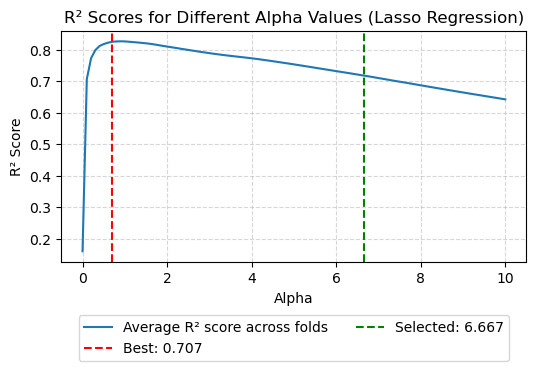

In [ ]:
plt.figure(figsize=(6, 3))
mean_alpha_scores = np.mean(all_alpha_scores, axis=0)  # Average R² score for each alpha across all folds
plt.plot(alphas, mean_alpha_scores, label='Average R² score across folds')

# Round values to 3 decimal places
best_alpha_rounded = round(best_alpha, 3)
selected_alpha_rounded = round(alphas[selected_model_idx], 3)

plt.axvline(best_alpha, color='r', linestyle='--', label=f"Best alpha: {best_alpha_rounded}")
plt.axvline(alphas[selected_model_idx], color='g', linestyle='--', label=f"Best alpha after 1-std-rule: {selected_alpha_rounded}")

plt.xlabel('Alpha')
plt.ylabel('R² Score')
plt.title('R² Scores for Different Alpha Values (Lasso Regression)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)  # Move legend below the graph
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# ElasticNet

In [80]:
# Define hyperparameter grid
alphas = np.linspace(0.01, 10, 50)  # Avoid zero to prevent no regularization
l1_ratios = np.linspace(0, 1, 10)   # From Ridge (0) to Lasso (1)

# Outer cross-validation (e.g., 10-fold)
outer_cv = KFold(n_splits=10, shuffle=True, random_state=1)

# Store results
test_r2 = []
test_RMSE = []
test_MSE = []

# Store scores for all (alpha, l1_ratio) combinations in all folds
all_alpha_l1_scores = []
alpha_l1_means = []
alpha_l1_stds = []

# Outer cross-validation loop
for train_idx, test_idx in outer_cv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    X_train, X_test, y_train, y_test = handlingOfdata(X_train, X_test, y_train, y_test)

    # Inner cross-validation for hyperparameter tuning
    best_score = -np.inf
    best_alpha = None
    best_l1_ratio = None

    inner_cv = KFold(n_splits=10, shuffle=True, random_state=1)

    fold_alpha_l1_scores = []
    fold_means = []
    fold_stds = []

    for alpha in alphas:
        for l1_ratio in l1_ratios:
            inner_r2, inner_RMSE, inner_MSE = [], [], []

            for inner_train_idx, inner_val_idx in inner_cv.split(X_train):
                X_inner_train, X_val = X_train.iloc[inner_train_idx], X_train.iloc[inner_val_idx]
                y_inner_train, y_val = y_train.iloc[inner_train_idx], y_train.iloc[inner_val_idx]

                model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
                model.fit(X_inner_train, y_inner_train)

                y_pred = model.predict(X_val)
                inner_r2.append(r2_score(y_val, y_pred))
                inner_RMSE.append(np.sqrt(mean_squared_error(y_val, y_pred)))
                inner_MSE.append(mean_squared_error(y_val, y_pred))

            # Compute mean and std across inner folds
            mean_inner_r2 = np.mean(inner_r2)
            std_inner_r2 = np.std(inner_r2)

            fold_means.append(mean_inner_r2)
            fold_stds.append(std_inner_r2)

            # Store mean R² for this (alpha, l1_ratio) pair
            fold_alpha_l1_scores.append(mean_inner_r2)

            # Select best (alpha, l1_ratio) based on highest mean R²
            if mean_inner_r2 > best_score:
                best_score = mean_inner_r2
                best_alpha = alpha
                best_l1_ratio = l1_ratio

    # Store all scores for this outer fold
    all_alpha_l1_scores.append(fold_alpha_l1_scores)
    alpha_l1_means.append(fold_means)
    alpha_l1_stds.append(fold_stds)

    # Train final model with best alpha and l1_ratio on full outer training set
    final_model = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio)
    final_model.fit(X_train, y_train)

    # Evaluate on outer test set
    y_pred = final_model.predict(X_test)
    test_r2.append(r2_score(y_test, y_pred))
    test_RMSE.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    test_MSE.append(mean_squared_error(y_test, y_pred))

# Convert lists to NumPy arrays for easier indexing
alpha_l1_means = np.array(alpha_l1_means)  # Shape: (n_folds, n_alpha * n_l1)
alpha_l1_stds = np.array(alpha_l1_stds)

# Report final performance estimates
print(f'One standard error rule selects model with alpha: {best_alpha}, l1_ratio: {best_l1_ratio}')
print("Final estimated R² score (mean over outer folds):", np.mean(test_r2))
print("Final estimated MSE score (mean over outer folds):", np.mean(test_MSE))
print("Final estimated RMSE score (mean over outer folds):", np.mean(test_RMSE))

One standard error rule selects model with alpha: 0.8255102040816327, l1_ratio: 1.0
Final estimated R² score (mean over outer folds): 0.7881430544628352
Final estimated MSE score (mean over outer folds): 807.4300145730856
Final estimated RMSE score (mean over outer folds): 27.957029240375345


In [101]:
# Apply the One Standard Error Rule
mean_r2_all_folds = np.mean(alpha_l1_means, axis=0)
std_r2_all_folds = np.mean(alpha_l1_stds, axis=0)

mean_r2_all_folds_reshaped = mean_r2_all_folds.reshape(len(alphas), len(l1_ratios))
std_r2_all_folds_reshaped = std_r2_all_folds.reshape(len(alphas), len(l1_ratios))

# Apply the One Standard Error Rule
best_mean_r2_idx = np.argmax(mean_r2_all_folds_reshaped)
best_mean_r2 = mean_r2_all_folds_reshaped.flatten()[best_mean_r2_idx]  # Flatten for easy access
best_std_r2 = std_r2_all_folds_reshaped.flatten()[best_mean_r2_idx]  # Flatten for easy access

acceptable_models = [
    (i, j) for i in range(len(alphas)) for j in range(len(l1_ratios))
    if best_mean_r2 - best_std_r2 <= mean_r2_all_folds_reshaped[i, j]
]

# Select the model with the highest alpha among the acceptable models
if len(acceptable_models) > 0:
    selected_model_idx = acceptable_models[-1]  # Select the most regularized model
else:
    selected_model_idx = np.unravel_index(np.argmax(mean_r2_all_folds_reshaped), mean_r2_all_folds_reshaped.shape)

# Extract the hyperparameters for the selected model
alpha_selected = alphas[selected_model_idx[0]]
l1_ratio_selected = l1_ratios[selected_model_idx[1]]

# Print the hyperparameters of the selected model
print(f'One standard error rule selects model with alpha: {alpha_selected}, l1_ratio: {l1_ratio_selected}')
print(f'One standard error rule gives the best model with mean_test_score (R²): {mean_r2_all_folds_reshaped[selected_model_idx]} and std_test_score: {std_r2_all_folds_reshaped[selected_model_idx]}')

One standard error rule selects model with alpha: 6.737959183673469, l1_ratio: 1.0
One standard error rule gives the best model with mean_test_score (R²): 0.7165201165555115 and std_test_score: 0.16355521385009664


# PLS

In [108]:
# Define hyperparameter grid
n_components = range(1, 101)  # Start from 1, as PLSRegression does not allow 0 components

# Outer cross-validation (e.g., 10-fold)
outer_cv = KFold(n_splits=10, shuffle=True, random_state=1)

# Store results
test_r2 = []
test_RMSE = []
test_MSE = []

# Store R² scores for all components in all folds
all_component_scores = []

# Initialize means and stds for number of components
component_means = []
component_stds = []

# Outer cross-validation loop
for train_idx, test_idx in outer_cv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    X_train, X_test, y_train, y_test = handlingOfdata(X_train, X_test, y_train, y_test)

    # Inner cross-validation for hyperparameter tuning
    best_score = -np.inf
    best_n_component = None

    inner_cv = KFold(n_splits=10, shuffle=True, random_state=1)

    fold_component_scores = []  # To store R² scores for each n_component in the current fold

    # Initialize lists to store mean and std for each n_component across inner folds
    inner_component_means = []
    inner_component_stds = []

    for n_component in n_components:
        inner_r2, inner_RMSE, inner_MSE = [], [], []
        for inner_train_idx, inner_val_idx in inner_cv.split(X_train):
            X_inner_train, X_val = X_train.iloc[inner_train_idx], X_train.iloc[inner_val_idx]
            y_inner_train, y_val = y_train.iloc[inner_train_idx], y_train.iloc[inner_val_idx]

            model = PLSRegression(n_components=n_component)
            model.fit(X_inner_train, y_inner_train)
            
            y_pred = model.predict(X_val)
            
            inner_r2.append(r2_score(y_val, y_pred))
            inner_RMSE.append(mean_squared_error(y_val, y_pred, squared=False))  # RMSE
            inner_MSE.append(mean_squared_error(y_val, y_pred))

        # Calculate mean and std across inner folds
        mean_inner_r2 = np.mean(inner_r2)
        std_inner_r2 = np.std(inner_r2)

        inner_component_means.append(mean_inner_r2)
        inner_component_stds.append(std_inner_r2)

        fold_component_scores.append(mean_inner_r2)  # Store mean R² score for the current component

        if mean_inner_r2 > best_score:
            best_score = mean_inner_r2
            best_n_component = n_component

    # Store the R² scores for all components in this fold
    all_component_scores.append(fold_component_scores)

    # Add inner component means and stds for the current fold to the overall list
    component_means.append(inner_component_means)
    component_stds.append(inner_component_stds)

    # Train final model with best n_component on full outer training set
    final_model = PLSRegression(n_components=best_n_component)
    final_model.fit(X_train, y_train)

    # Evaluate on outer test set
    y_pred = final_model.predict(X_test)
    test_r2.append(r2_score(y_test, y_pred))
    test_RMSE.append(mean_squared_error(y_test, y_pred, squared=False))  # RMSE
    test_MSE.append(mean_squared_error(y_test, y_pred))

# Convert component_means and component_stds into NumPy arrays for easier indexing
component_means = np.array(component_means)  # Shape: (n_folds, n_components)
component_stds = np.array(component_stds)    # Shape: (n_folds, n_components)

# Report final performance estimates
print(f'Optimal number of components: {best_n_component}')
print("Final estimated R² score (mean over outer folds):", np.mean(test_r2))
print("Final estimated MSE score (mean over outer folds):", np.mean(test_MSE))
print("Final estimated RMSE score (mean over outer folds):", np.mean(test_RMSE))

Optimal number of components: 4
Final estimated R² score (mean over outer folds): 0.6048675574213732
Final estimated MSE score (mean over outer folds): 1419.633036886267
Final estimated RMSE score (mean over outer folds): 36.95367888423611


In [110]:
# Apply the One Standard Error Rule for PLS

# Get the best model's mean R² score and std deviation across all folds
mean_r2_all_folds = np.mean(alpha_means, axis=0)
std_r2_all_folds = np.mean(alpha_stds, axis=0)

# Find the models where mean R² is within 1 standard error of the best R²
best_mean_r2 = np.max(mean_r2_all_folds)
best_std_r2 = std_r2_all_folds[np.argmax(mean_r2_all_folds)]  # Corresponding std for the best mean

acceptable_models = [i for i, mean_r2 in enumerate(mean_r2_all_folds) if best_mean_r2 - best_std_r2 <= mean_r2]

# Select the model with the highest number of components among the acceptable models
if len(acceptable_models) > 0:
    selected_model_idx = acceptable_models[0]  # Select the most regularized model (fewer components)
else:
    selected_model_idx = np.argmax(mean_r2_all_folds)  # If no model satisfies the rule, keep the best one

# Print the hyperparameters of the selected model
print(f'One standard error rule selects model with n_components: {n_components[selected_model_idx]}')
print(f'One standard error rule gives the best model with mean_test_score (R²): {mean_r2_all_folds[selected_model_idx]} and std_test_score: {std_r2_all_folds[selected_model_idx]}')

One standard error rule selects model with n_components: 2
One standard error rule gives the best model with mean_test_score (R²): 0.7039238727400156 and std_test_score: 0.18464479518480575


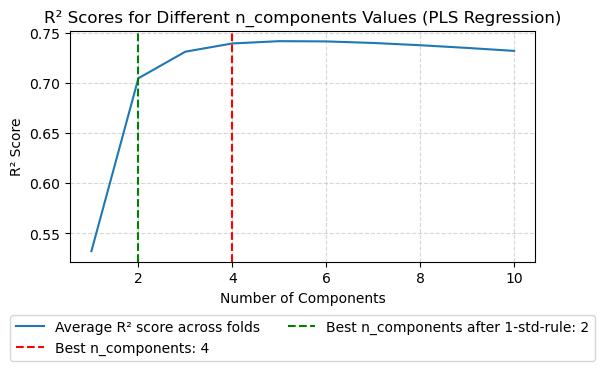

In [119]:
plt.figure(figsize=(6, 3))
mean_component_scores = np.mean(all_alpha_scores, axis=0)  # Average R² score for each n_components across all folds
plt.plot(n_components[:10], mean_component_scores[:10], label='Average R² score across folds')

# Round values to 3 decimal places
best_n_component_rounded = round(best_n_component, 3)
selected_n_component_rounded = round(n_components[selected_model_idx], 3)

plt.axvline(best_n_component, color='r', linestyle='--', label=f"Best n_components: {best_n_component_rounded}")
plt.axvline(n_components[selected_model_idx], color='g', linestyle='--', label=f"Best n_components after 1-std-rule: {selected_n_component_rounded}")
plt.xlabel('Number of Components')
plt.ylabel('R² Score')
plt.title('R² Scores for Different n_components Values (PLS Regression)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)  # Move legend below the graph
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()